# Preface

This is the python code appendix (2/2) of the research paper "Social interactions in volatile markets - a GameStop story".

# Gather GameStop price data

In [1]:
# pip install alpha_vantage

## Connect to API and download monthly data

In [24]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

apiKey = '4OKA4AHOIV34TCGW'

ts = TimeSeries(key = apiKey, output_format = 'csv')

# Standard API call frequency is 5 calls per minute and 500 calls per day
# we need data from Sept 2020-11-30 - 2021-09-30
x = 11
# for x in range(1,5):
print(x)
totalData = ts.get_intraday_extended(symbol = 'GME', interval = '60min', slice = 'year1month'+str(x))


df = pd.DataFrame(list(totalData[0]))

#setup of column and index
header_row=0
df.columns = df.iloc[header_row]
df = df.drop(header_row)
df.set_index('time', inplace=True)

#show output
print(df)

df.to_csv('stockdata'+str(x)+'.csv')

11
0                      open   high    low  close    volume
time                                                      
2021-01-22 20:00:00    63.6   63.6   61.0   61.0    279826
2021-01-22 19:00:00    64.0  64.88  62.35   63.7    152240
2021-01-22 18:00:00    67.5  67.89  63.01   63.8    942544
2021-01-22 17:00:00    65.0  68.46   62.4   67.6   2300243
2021-01-22 16:00:00  59.185   68.0   57.2  64.85  30044433
...                     ...    ...    ...    ...       ...
2020-12-28 09:00:00    22.1  22.57  21.26  21.44    158480
2020-12-28 08:00:00    22.5   22.5  21.59   22.3     65176
2020-12-28 07:00:00   22.48  22.53   22.2   22.4      5334
2020-12-28 06:00:00    22.6  22.88  22.06  22.52      8735
2020-12-28 05:00:00   20.25   23.5   20.2  23.29     17963

[278 rows x 5 columns]


## Merge monthly data to single data frame 

Alpha Vantage gives out one month, so combining the stock data results in stockdatafull.csv which can be imported and adapted afterwards

In [32]:
import os
import glob
import pandas as pd

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "stockdatafull.csv", index=False, encoding='utf-8-sig')

df = pd.read_csv('stockdatafull.csv', delimiter=',')
df = df.drop(1)
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df.set_index('time', inplace=True)
df.to_csv('stockdatafull.csv', header=True, index=True,)
df

,open,high,low,close,volume
time,,,,,
2021-11-19 20:00:00,229.0000,229.00,228.52,229.00,2269
2021-11-19 18:00:00,228.5000,230.00,228.50,230.00,9977
2021-11-19 17:00:00,228.8000,230.48,228.05,228.67,37861
2021-11-19 16:00:00,224.5200,228.80,223.62,228.80,622632
2021-11-19 15:00:00,222.4599,229.39,220.48,224.43,916181
...,...,...,...,...,...
2021-02-23 09:00:00,43.8900,45.55,43.80,44.37,120850
2021-02-23 08:00:00,44.5200,45.24,43.82,43.84,48033
2021-02-23 07:00:00,43.8000,44.40,42.87,44.40,27430


# Fit stock data to UTC

In [5]:
# Add 5 hours from time (EST), since UTC timezone is needed for combining pricing data with Reddit data
from datetime import timedelta
import pandas as pd
import pytz


df = pd.read_csv('stockdatafull.csv', delimiter=',')
df

df = df.drop(1)
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df.set_index('time', inplace=True)

eastern = pytz.timezone('US/Eastern')
df.index = df.index.tz_localize('US/Eastern').tz_convert('UTC')

# df.index = df.index.tz_localize('EST')
# df.index = df.index.tz_convert('Europe/Vienna')

# df['time'] = pd.to_datetime(df['time']) + timedelta(hours=5)
df.to_csv('stockdata_UTC.csv')
df

,open,high,low,close,volume
time,,,,,
2021-11-20 01:00:00+00:00,229.0000,229.00,228.5200,229.000,2269
2021-11-19 22:00:00+00:00,228.8000,230.48,228.0500,228.670,37861
2021-11-19 21:00:00+00:00,224.5200,228.80,223.6200,228.800,622632
2021-11-19 20:00:00+00:00,222.4599,229.39,220.4800,224.430,916181
2021-11-19 19:00:00+00:00,217.4500,222.99,217.1601,222.565,411816
...,...,...,...,...,...
2021-02-23 14:00:00+00:00,43.8900,45.55,43.8000,44.370,120850
2021-02-23 13:00:00+00:00,44.5200,45.24,43.8200,43.840,48033
2021-02-23 12:00:00+00:00,43.8000,44.40,42.8700,44.400,27430


*********************************

# Plot graphs

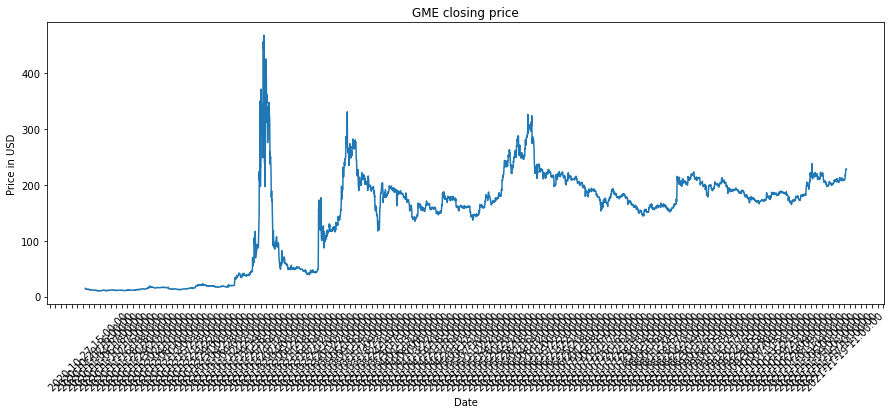

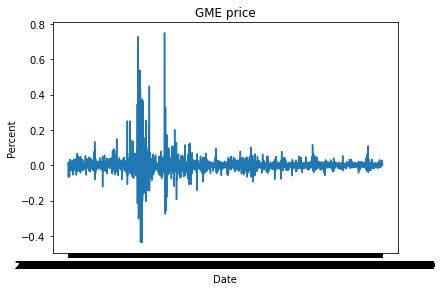

In [8]:
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates

# df = pd.read_csv('stockdata_UTC.csv', delimiter=',' , parse_dates=['time'], index_col=['time'])
# # convert the time column as datetime64[ns] instead of "object" variable
# df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
# pd.DatetimeIndex(df['time'])

# load and format the data
df = pd.read_csv('stockdata_UTC.csv')

df['time'] = pd.to_datetime(df['time'], format = "%Y-%m-%d %H:%M:%S").dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.drop_duplicates(subset="time")
df = df.sort_values(by = 'time')
df['returns'] = df['close'].pct_change()
df = df.dropna()
df.set_index('time', inplace=True)


# df = df[~df.index.duplicated(keep='first')]

# plot
fig = plt.figure(figsize=(15, 7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(df['close'], label='close')
plt.title('GME closing price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.gca().xaxis.set_tick_params(rotation = 45)
plt.show()


fig = plt.figure()
ax1 = fig.add_axes([1,1,0.8,0.8])
ax1.plot(df.returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("GME price")
ax1.xaxis.set_tick_params(rotation = 45)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.show()

df.to_csv('stockdata_UTC_final.csv')